In [1]:
import os
import sys
import numpy as np

from highd_utils.read_csv import *
from highd_utils.visualize_frame import VisualizationPlot

In [13]:
options = {}
options['input_path'] = "./raw/highD-dataset-v1.0/data/"
options['track_files'] = "%02d_tracks.csv"
options['track_meta_files'] = "%02d_tracksMeta.csv"
options['rec_meta_files'] = "%02d_recordingMeta.csv"
options['min_track'] = 1 # min number to load
options['max_track'] = 5 #60 # max number to load
options['min_track_length'] = 200 # min track length
options['max_track_length'] = 350 # min track length
options['p_keep_straight'] = 0.0 # Probability to keep a straight car (0.0 = lane changes only, 1.0 = full dataset)
options['frame_rate'] = 4 # Keep every nth frame. Note recorded frame rate is 25 Hz
options['locations'] = [1,2,3,4,5,6]
options['features'] = ['x','y','dhw','thw']
options['randseed'] = 1
options['output_dir'] = "./processed/"
options['output_file'] = "highd_processed_tracks%02d-%02d_fr%02d_loc%s_p%3.2f.pt" %(
    options['min_track'],options['max_track'], 
    options['frame_rate'], "".join([str(i) for i in options['locations']]), 
    options['p_keep_straight'])

In [15]:
def read_all_data(options):
    """
    This method reads in the highD dataset given options
    :param options: the options for the preprocessing.
    :return: dicts for each recording of track info, static metadata, and recording metadata.
    """
    all_tracks, all_static, all_rec = {}, {}, {}
    np.random.seed(options['randseed']) #seed rng
    
    for track in range(options['min_track'],options['max_track']+1):
        print("Loading track %02d in %02d : %02d." %(track, options['min_track'], options['max_track']))

        # Make pathnames for current track
        if not os.path.exists(options['input_path']):
            print("Invalid input path. Make sure dataset is put in correct place")
            sys.exit(1)
        track_path = os.path.join(options['input_path'], (options['track_files'] % (track)))
        track_meta_path = os.path.join(options['input_path'], (options['track_meta_files'] % (track)))
        rec_meta_path = os.path.join(options['input_path'], (options['rec_meta_files'] % (track)))

        # Read the recording meta info
        try:
            meta_dictionary = read_meta_info(rec_meta_path)
        except:
            print("The video meta file is either missing or contains incorrect characters.")
            sys.exit(1)

        # Move on if not at desired location
        if meta_dictionary['locationId'] not in options['locations']:
            print("Track %02d not in locations." %(track))
            continue

        # Read the track meta info
        try:
            tracks = read_track_csv(track_path)
        except:
            print("The track file is either missing or contains incorrect characters.")
            sys.exit(1)

        # Read the track static meta info
        try:
            static_info = read_static_info(track_meta_path)
        except:
            print("The static info file is either missing or contains incorrect characters.")
            sys.exit(1)

        # Remove tracks that are too short or (probabilistically) have no lane change
        rm_keys = []
        for car in range(1,meta_dictionary['numVehicles']+1):
            if (static_info[car]['numLaneChanges'] == 0 and np.random.rand()>options['p_keep_straight']):
                rm_keys.append(car)
                continue
            if (static_info[car]['numFrames'] < options['min_track_length']):
                rm_keys.append(car)

        print("Removing %d out of %d frames." %(len(rm_keys),meta_dictionary['numVehicles']+1) )
        for car in reversed(rm_keys):
            del static_info[car] # dict keyed by car
            del tracks[car-1] # list indexed by car-1


        # Store in master dicts
        all_tracks[track] = tracks
        all_static[track] = static_info
        all_rec[track] = meta_dictionary
        
    return all_tracks, all_static, all_rec
all_tracks, all_static, all_rec = read_all_data(options)

Loading track 01 in 01 : 05.
Removing 913 out of 1048 frames.
Loading track 02 in 01 : 05.
Removing 994 out of 1114 frames.
Loading track 03 in 01 : 05.
Removing 799 out of 915 frames.
Loading track 04 in 01 : 05.
Removing 923 out of 1164 frames.
Loading track 05 in 01 : 05.
Removing 966 out of 1217 frames.


In [16]:
def clean_feature(raw, options, feature):
    """
    This method cleans a single feature for a single car track.
    :param raw: the raw input feature.
    :param options: the options for the preprocessing.
    :param feature: the feature name being cleaned.
    :return: a 1d numpy array of the cleaned feature.
    """
    n = len(raw)
    data = np.array(raw)
    
    # center x and y values
    if feature in ['x','y']:
        data = data - data[0]
    
    # if data too short, extend appropriately
    if n < options['max_track_length']:
        ext = options['max_track_length'] - n
        
        # features to store last value
        if feature in ['y','dhw','thw']:
            data = np.append(data,[data[-1]] * ext)
        
        # features to extrapolate
        if feature == 'x':
            vel = (data[-1] - data[-1-5])/5
            extrap = data[-1] + vel*np.arange(1,ext+1)
            data = np.concatenate((data,extrap))
    
    # truncate if over max track length
    elif n > options['max_track_length']:
        data = data[:options['max_track_length']]
    
    # replace zeros in dhw and thw
    if feature == 'dhw':
        data[data==0] = 500 # 500m to collision if no car
    if feature == 'thw':
        data[data==0] = 6 # 6s to collision if no car
        
    return data

def combine_data(all_tracks, options):
    """
    This method extracts, cleans, and combines features over all saved recordings and tracks.
    :param all_tracks: a dictionary of recordings, each with a reduced list of cars.
    :param options: the options for the preprocessing.
    :return: a dict mapping feature name to a (cars, frames) cleaned numpy array.
    """
    # initialize data dictionary and data lists
    data = {}
    for feature in options['features']:
        data[feature] = np.zeros((0,options['max_track_length']))
    
    # iterate over all tracks and recordings, add data to numpy array
    for rec in all_tracks.keys():
        for car in all_tracks[rec]:
            for feature in options['features']:
                
                # clean feature (fix length, fix zeros, subtract initial points)
                cleaned = clean_feature(car[feature], options, feature)
                
                # add to data vector
                data[feature] = np.vstack((data[feature], cleaned))
    return data 

In [17]:
combine = combine_data(all_tracks, options)

In [18]:
combine

{'x': array([[   0.   ,   -1.32 ,   -2.7  , ..., -505.   , -506.454, -507.908],
        [   0.   ,    0.89 ,    1.83 , ...,  352.896,  353.968,  355.04 ],
        [   0.   ,   -1.14 ,   -2.34 , ..., -432.83 , -434.068, -435.306],
        ...,
        [   0.   ,    1.62 ,    3.32 , ...,  605.214,  606.93 ,  608.646],
        [   0.   ,    1.33 ,    2.69 , ...,  505.742,  507.214,  508.686],
        [   0.   ,   -1.52 ,   -3.1  , ..., -574.764, -576.42 , -578.076]]),
 'y': array([[ 0.  ,  0.  , -0.01, ...,  3.99,  3.99,  3.99],
        [ 0.  ,  0.  ,  0.  , ..., -3.62, -3.62, -3.62],
        [ 0.  ,  0.  ,  0.  , ..., -2.91, -2.91, -2.91],
        ...,
        [ 0.  ,  0.02,  0.05, ...,  3.59,  3.59,  3.59],
        [ 0.  ,  0.01,  0.02, ..., -3.68, -3.68, -3.68],
        [ 0.  ,  0.01,  0.03, ...,  3.28,  3.28,  3.28]]),
 'dhw': array([[ 72.68,  72.51,  72.34, ..., 500.  , 500.  , 500.  ],
        [ 15.67,  15.64,  15.61, ..., 500.  , 500.  , 500.  ],
        [500.  , 500.  , 500.  , ..

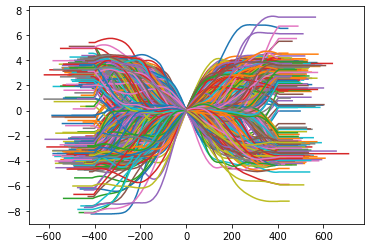

In [21]:
import matplotlib.pyplot as plt
plt.plot(combine['x'].T,combine['y'].T)
plt.show()

In [ ]:
def feature_dict_to_tensor(feature_dict, options)    
    # turn data dict into (# frames, # cars, # features) tensor
    return data_tensor

def reduce_frame_rate(data_tensor, options)
    # reduce tensor based on the desired frame rate
    return reduced_tensor

def save_tensor(data_tensor, options)
    """
    This saves the processed torch tensor.
    :param data_tensor: the cleaned torch data tensor.
    :param options: the options for the preprocessing.
    """
    
    if not os.path.exists(options['output_dir']):
        os.mkdir(options['output_dir'])    
    torch.save(data_tensor, os.path.join(options['output_dir'], options['output_file']))

(array([  1.,   0.,   0.,   7.,  36., 109., 127.,  61.,  20.,   8.]),
 array([115. , 146.1, 177.2, 208.3, 239.4, 270.5, 301.6, 332.7, 363.8,
        394.9, 426. ]),
 <a list of 10 Patch objects>)

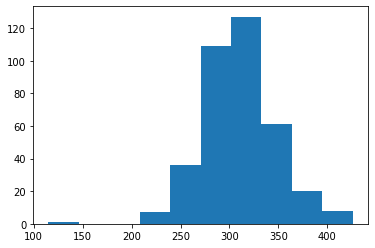

In [25]:
frames = []
for rec in all_static.keys():
    for car in all_static[rec].keys():
        frames.append(all_static[rec][car]['numFrames'])
        
import matplotlib.pyplot as plt
plt.hist(frames) # based on this histogram, requiring a minimum of 200 frames